<a href="https://colab.research.google.com/github/nicoRomeroCuruchet/DynamicProgramming/blob/main/testing_bary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from PolicyIteration import PolicyIteration


def plot_2D_value_function(data: dict, normalize: bool = True, cmap:str="OrRd_r")->None:
    """
    Plots a 2D value function in some color scale.

    Parameters:
    - data (dict): A dictionary containing the value function data. The keys represent the position and velocity, and the values represent the meaning.
    - normalize (bool): Whether to normalize the value function. Defaults to True.
    - cmap (str): The colormap to use for the contour plot. Defaults to "OrRd_r".

    Returns:
    None
    """
    # Extract position, velocity, and meaning from the dictionary
    positions = np.array([key[0] for key in data.keys()])
    velocities = np.array([key[1] for key in data.keys()])
    meanings = np.array(list(data.values()))
    max = np.max(meanings) if normalize else 1.0

    # Create grid data
    pos_grid, vel_grid = np.meshgrid(np.unique(positions), np.unique(velocities))

    # Create a grid for the meanings
    mean_grid = np.zeros_like(pos_grid, dtype=float)

    for i in range(pos_grid.shape[0]):
        for j in range(pos_grid.shape[1]):
            pos = pos_grid[i, j]
            vel = vel_grid[i, j]
            mean_grid[i, j] = data.get((pos, vel), np.nan) / max # Use np.nan for missing values

    # Create a filled contour plot
    fig, ax = plt.subplots()

    # Create the contour plot with grayscale color map
    contour = ax.contourf(pos_grid, vel_grid, mean_grid, cmap=cmap)

    # Add contour lines
    contour_lines = ax.contour(pos_grid, 
                            vel_grid, 
                            mean_grid, 
                            colors='k',
                            linewidths=0.45, 
                            linestyles='dashed')

    # Add labels to the contour lines
    ax.clabel(contour_lines, inline=True, fontsize=8)
    # Set labels
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    # Mark the target position
    target_position = 0.45
    target_velocity = 0.0
    ax.plot(target_position, target_velocity, 'kx')  # 'rx' means red color and x marker
    ax.text(target_position, target_velocity, ' Target', color='k', fontsize=10, ha='left', va='bottom')
    # Add a color bar which maps values to colors
    cbar = fig.colorbar(contour)
    cbar.set_label('Normalize value function')
    # save the plot
    plt.savefig('2D_value_function.png')
    # Show the plot
    plt.show()
    


def plot_3D_value_function(vf: dict, normalize: bool = True, cmap:str="OrRd_r")->None:
    """
    Plots a 3D surface plot of a value function.

    Parameters:
    - vf (dict): A dictionary representing the value function. The keys are tuples of (position, velocity),
                 and the values are the corresponding meanings.
    - normalize (bool): Whether to normalize the value function. If True, the values will be normalized between 0 and 1.

    Returns:
    None
    """
    # Extract position, velocity, and meaning from the dictionary
    positions = [key[0] for key in vf.keys()]
    velocities = [key[1] for key in vf.keys()]
    max = np.max(list(vf.values())) if normalize else 1.0
    # Create grid vf
    pos_grid, vel_grid = np.meshgrid(np.unique(positions), np.unique(velocities))
    # Create a grid for the meanings
    mean_grid = np.zeros_like(pos_grid, dtype=float)
    # Normalize the meanings
    for i in range(pos_grid.shape[0]):
        for j in range(pos_grid.shape[1]):
            pos = pos_grid[i, j]
            vel = vel_grid[i, j]
            mean_grid[i, j] = vf.get((pos, vel), np.nan)  / max # Use np.nan for missing values

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Plot the surface
    surf = ax.plot_surface(pos_grid, vel_grid, mean_grid, cmap=cmap)
    # Set labels
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_xticks(np.linspace(np.min(positions), np.max(positions), num=5))
    ax.set_yticks(np.linspace(np.min(velocities), np.max(velocities), num=4))
    # Add a color bar which maps values to colors
    fig.colorbar(surf, shrink=0.5, aspect=35, label='Normalize value function')
    # save the plot
    plt.savefig('3D_value_function.png')
    # Show the plot
    plt.show()
    

def get_optimal_action(state:np.array, optimal_policy:PolicyIteration):
    """
    Aproximate the optimal action for a given state using the provided optimal policy
    with barycentric interpolation.

    Parameters:
    state (np.array): The state for which to determine the optimal action.
    optimal_policy (PolicyIteration): The optimal policy used to determine the action.

    Returns:
    action: The optimal action for the given state.
    """
    _, neighbors  = optimal_policy.kd_tree.query([state], k=optimal_policy.num_simplex_points)
    simplex       = optimal_policy.points[neighbors[0]]
    lambdas       = optimal_policy.barycentric_coordinates(state, simplex)

    actions = optimal_policy.action_space
    probabilities = np.zeros(len(actions))

    for i, l in enumerate(lambdas):
        for j, action in enumerate(actions):
            if optimal_policy.policy[tuple(simplex[i])][action] > 0:
                probabilities[j] += l

    argmax = lambda x: max(enumerate(x), key=lambda x: x[1])[0]
    action = actions[argmax(probabilities)]

    return action


def test_enviroment(task: gym.Env, 
                    pi: PolicyIteration, 
                    num_episodes: int = 10000, 
                    episode_lengh: int = 1000,
                    option_reset:dict=None):
    """
    Test the environment using the given policy iteration algorithm.

    Parameters:
    - task (gym.Env): The environment to test.
    - pi (PolicyIteration): The policy iteration algorithm.
    - num_episodes (int): The number of episodes to run. Default is 10000.
    - episode_lengh (int): The maximum length of each episode. Default is 1000.
    """

    for episode in range(0, num_episodes):
        total_reward = 0
        observation, _ = task.reset(options=option_reset)
        for timestep in range(1, episode_lengh):
            action = get_optimal_action(observation, pi)
            observation, reward, terminated, _, _ = task.step(action)
            total_reward += reward
            if terminated:
                print(f"Episode {episode} finished after {timestep} timesteps")
                print(f"Total reward: {total_reward}")
                break

In [1]:
import numpy as np
import pickle
from PolicyIteration import PolicyIteration

from utils.utils import plot_2D_value_function,\
                  plot_3D_value_function,\
                  test_enviroment

# CartPoleEnv 

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
of the fixed force the cart is pushed with.

- 0: Push cart to the left
- 1: Push cart to the right

In [ ]:
# Train cartpole environment:

from classic_control.cartpole import CartPoleEnv

env = CartPoleEnv(sutton_barto_reward=True)
# position thresholds:
x_lim = 2.5
theta_lim = 0.25 
# velocity thresholds:
x_dot_lim = 2.5
theta_dot_lim = 2.5

bins_space = {
    "x_space": np.linspace(-x_lim, x_lim, 20),                         # position space         (0)
    "x_dot_space": np.linspace(-x_dot_lim, x_dot_lim, 20),             # velocity space         (1)
    "theta_space": np.linspace(-theta_lim, theta_lim, 20),             # angle space            (2)
    "theta_dot_space": np.linspace(-theta_dot_lim, theta_dot_lim, 20), # angular velocity space (3)
}

pi = PolicyIteration(
    env=env, 
    bins_space=bins_space,
    action_space=[0, 1],
    gamma=0.99,
    theta=1e-3
)

pi.run()

In [ ]:
# Test cartpole environment:

with open(env.__class__.__name__ + ".pkl", "rb") as f:
    pi = pickle.load(f)

test_enviroment(CartPoleEnv(sutton_barto_reward=True, render_mode="human"), pi)

# Continuous_MountainCarEnv

## Observation Space

The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:

| Num | Observation                          | Min  | Max | Unit         |
|-----|--------------------------------------|------|-----|--------------|
| 0   | position of the car along the x-axis | -Inf | Inf | position (m) |
| 1   | velocity of the car                  | -Inf | Inf | position (m) |

## Action Space

The action is a `ndarray` with shape `(1,)`, representing the directional force applied on the car.
The action is clipped in the range `[-1,1]` and multiplied by a power of 0.0015.


In [2]:
# Train mountain car environment:

from classic_control.continuous_mountain_car import Continuous_MountainCarEnv

env=Continuous_MountainCarEnv()

bins_space = {
    "x_space":     np.linspace(env.min_position, env.max_position, 250),      # position space         (0)
    "x_dot_space": np.linspace(-abs(env.max_speed), abs(env.max_speed), 250), # velocity space         (1)
}

pi = PolicyIteration(
    env=env, 
    bins_space=bins_space,
    action_space=[-1, 1],
    gamma=0.99,
    theta=1e-3,
)

pi.run()

2024-05-15 15:11:26.762 | INFO     | PolicyIteration:__init__:96 - Policy Iteration was correctly initialized.
2024-05-15 15:11:26.763 | INFO     | PolicyIteration:__init__:97 - The enviroment name is: Continuous_MountainCarEnv
2024-05-15 15:11:26.764 | INFO     | PolicyIteration:__init__:98 - The action space is: [-1, 1]
2024-05-15 15:11:26.764 | INFO     | PolicyIteration:__init__:99 - Number of states: 62500


In [3]:
# Test mountain car environment:

with open(env.__class__.__name__ + ".pkl", "rb") as f:
    pi = pickle.load(f)

test_enviroment(Continuous_MountainCarEnv(render_mode="human"), pi)

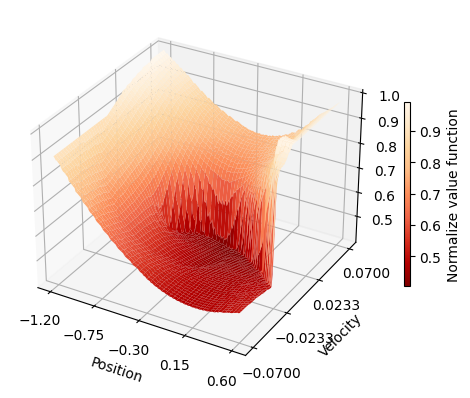

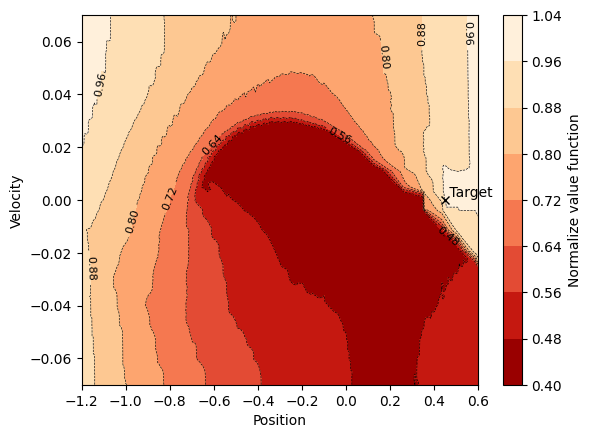

In [4]:
# graph the value function of the mountain car environment:
plot_3D_value_function(pi.value_function)
plot_2D_value_function(pi.value_function)